# 5.COCA 

In [1]:
import os
import sys
import pickle
import json
import glob
import gc
import random
import time
import unicodedata
import traceback
import datetime
import copy

import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm
from pathlib import Path
from scipy.spatial import distance
from collections import defaultdict
from PIL import Image
from collections import Counter

from sklearn.model_selection import train_test_split

sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
import open_clip

sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

In [2]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32-quickgelu', 'openai'),
 ('ViT-B-32-quickgelu', 'laion400m_e31'),
 ('ViT-B-32-quickgelu', 'laion400m_e32'),
 ('ViT-B-16', 'openai'),
 ('ViT-B-16', 'laion400m_e31'),
 ('ViT-B-16', 'laion400m_e32'),
 ('ViT-B-16', 'laion2b_s34b_b88k'),
 ('ViT-B-16-plus-240', 'laion400m_e31'),
 ('ViT-B-16-plus-240', 'laion400m_e32'),
 ('ViT-L-14', 'openai'),
 ('ViT-L-14', 'laion400m_e31'),
 ('ViT-L-14', 'laion400m_e32'),
 ('ViT-L-14', 'laion2b_s32b_b82k'),
 ('ViT-L-14-336', 'openai'),
 ('ViT-H-14', 'laion2b_s32b_

In [11]:
class CFG_CLASS:
    seed = 42
    text_emb_size = 384
    is_kaggle = (os.environ.get('PWD') == '/kaggle/working')
    train_files_dir: str = "img2prompt-data"
    
    clip_model = 'coca_ViT-L-14'
    pretrained = 'mscoco_finetuned_laion2b_s13b_b90k'
    model_name = f"model_{clip_model}_{pretrained}".replace("-", "_")
    
    # RESOURCES
    batch_size = 16
    num_workers = batch_size if not is_kaggle else 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    dataset_dupl_word = 2
    metadata_path = f"../input/metadata/metadata_duplwords_{dataset_dupl_word}.parquet"
    
    train_name = f"{model_name}"
    

CFG = CFG_CLASS()
CFG.train_name

'model_coca_ViT_L_14_mscoco_finetuned_laion2b_s13b_b90k'

In [4]:
model, img_train_transform, img_eval_transform = open_clip.create_model_and_transforms(
    CFG.clip_model, 
    pretrained=CFG.pretrained, 
    device=CFG.device
)

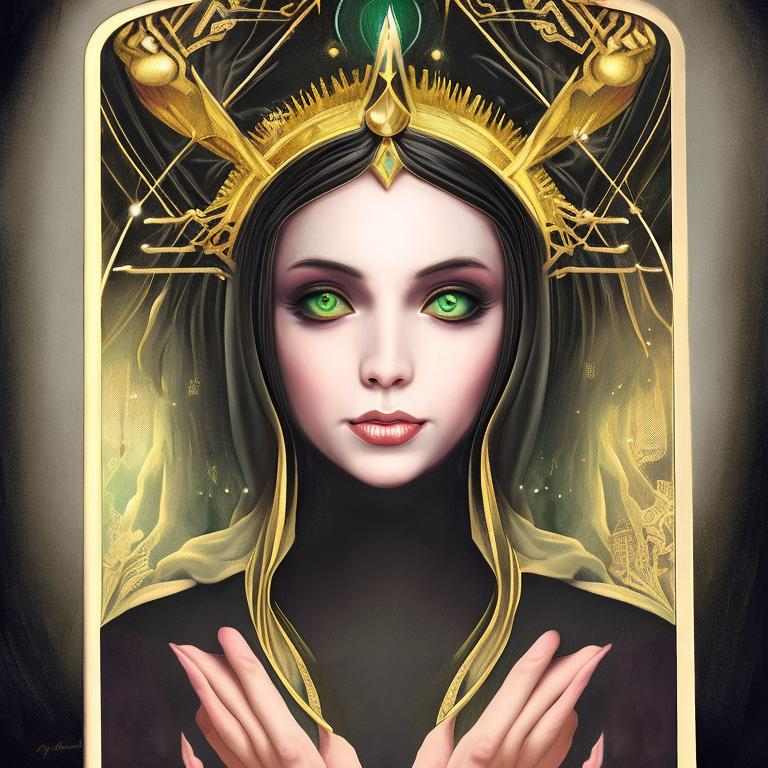

In [5]:
img = Image.open("../input/gustavosta-sd2-v2/eval_images/00000014.jpg")
img

In [6]:
img_tr = img_eval_transform(img).unsqueeze(0).to(CFG.device)

In [7]:
with torch.no_grad(), torch.cuda.amp.autocast():
    generated = model.generate(img_tr, 
                               min_seq_len=5, max_seq_len=77, 
                               seq_len=30, 
                               temperature=1, top_p=0.5, top_k=1,
                               repetition_penalty=10.0)
open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", "").rstrip(" .,")

'queen of wands'

# Validate

In [12]:
def get_sim(emb1, emb2):
    assert len(emb1.shape) <= 2 and len(emb1.shape) <= 2, "False shape"
    
    if len(emb1.shape) == 1:
        emb1 = [emb1]
    if len(emb2.shape) == 1:
        emb2 = [emb2]
    
    sim_res = 0
    for i in range(len(emb1)):
        sim_res += 1 - distance.cosine(emb1[i], emb2[i])
    return sim_res / (i + 1)

class CustomDataSet(Dataset):
    def __init__(self, data_dir, img2prompt, img_preprocess):
        self.data_dir = data_dir
        self.img_names = list(img2prompt.keys())
        self.img2prompt = img2prompt
        self.img_preprocess = img_preprocess

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path)
        img_emb = self.img_preprocess(img)
        
        prompt = str(self.img2prompt[img_name])
        
        return img_name, img_emb, prompt

In [13]:
st_model = SentenceTransformer('../input/sentence-transformers-222/all-MiniLM-L6-v2/')

train_data_dir = Path("../input/")

metadata = pd.read_parquet(CFG.metadata_path).sample(frac=0.01, random_state=CFG.seed)
full_prompt = metadata[["image_name", "prompt"]].values
val_prompt_dict = {img_name: prompt for img_name, prompt in full_prompt}

val_dataset = CustomDataSet(
    data_dir=train_data_dir, 
    img2prompt=val_prompt_dict, 
    img_preprocess=img_eval_transform,
)

val_dataloader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False,
                                    num_workers=CFG.num_workers)

In [14]:
from sklearn.model_selection import ParameterGrid
grid_params = {
    "seq_len": [30],
    "repetition_penalty": [10.],
}

model, img_train_transform, img_eval_transform = open_clip.create_model_and_transforms(
    CFG.clip_model, 
    pretrained=CFG.pretrained, 
    device=CFG.device
)

with torch.no_grad(), torch.cuda.amp.autocast():
    for param in ParameterGrid(grid_params):
        sim = 0
        for batch_i, (img_names, img_embs, true_prompts) in enumerate(bar := tqdm(val_dataloader, 
                                                                                  disable=False)):
            img_embs = img_embs.to(CFG.device)
            pred_tokens = model.generate(img_embs, **param)
            
            pred_prompts = []
            for tokens in pred_tokens:
                prompt = (
                    open_clip.decode(tokens)
                             .split("<end_of_text>")[0]
                             .replace("<start_of_text>", "")
                             .rstrip(" .,")
                )
                pred_prompts.append(prompt)
                
            pred_prompts_emb = st_model.encode(pred_prompts)
            true_prompts_emb = st_model.encode(true_prompts)
                
            sim += get_sim(pred_prompts_emb, true_prompts_emb)
            
        print(sim/(batch_i + 1), param)

  0%|          | 0/57 [00:00<?, ?it/s]

0.3318551649563392 {'repetition_penalty': 10.0, 'seq_len': 30}


In [15]:
pred_prompts

['an old wicker chair with a blanket draped over it',
 'there is an advertisement for mountain dewwell',
 'a stuffed animal like creature sitting on the ground']

In [166]:
open_clip.decode(generated[5])

'<start_of_text>1 2 8 0 x 1 0 2 4 prince of persia 2 0 1 3 game art 1 2 8 0 x 1 0 2 4 <end_of_text>'

In [ ]:
with torch.no_grad(), torch.cuda.amp.autocast():

    generated = model.generate(img_tr, 
                               min_seq_len=5, max_seq_len=77, 
                               seq_len=30, 
                               temperature=1, top_p=0.5, top_k=1,
                               repetition_penalty=10.0)
open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", "").rstrip(" .,")

In [ ]:
stats = pd.DataFrame()
for clip_model, pretrained in open_clip.list_pretrained():
    if clip_model in ["ViT-B-16"]:
        print(clip_model, pretrained)
        
        model, img_train_transform, img_eval_transform = open_clip.create_model_and_transforms(
            clip_model, 
            pretrained=pretrained, 
            device=CFG.device
        )
        text_tokenizer = open_clip.get_tokenizer(clip_model)
        
        labels_features = get_labels_features(
            labels=labels, 
            batch_size=CFG.batch_size, 
            device=CFG.device, 
            text_tokenizer=text_tokenizer, 
            model=model)
        
        model.eval()
        for k in list(range(1, 11, 1)) + [15, 20, 30]:
            sim_sum = 0
            with torch.no_grad(), torch.cuda.amp.autocast():
                for batch_i, (img_names, img_embs, true_prompts) in enumerate(bar := tqdm(val_dataloader, disable=True)):
                    img_embs = img_embs.to(CFG.device)
                    img_features = model.encode_image(img_embs, normalize=True)
                    labels_probs = (img_features @ labels_features.T)

                    pred_prompts = []
                    for i, top_label_ind in enumerate(labels_probs.topk(k).indices):
                        pred_prompt = ", ".join([labels[i] for i in top_label_ind])
                        pred_prompts.append(pred_prompt)

                    pred_prompts_emb = st_model.encode(pred_prompts)
                    true_prompts_emb = st_model.encode(true_prompts)

                    sim_i = get_sim(pred_prompts_emb, true_prompts_emb)
                    sim_sum += sim_i

                    bar.set_description(f"{sim_sum / (batch_i + 1)}")

            sim_sum /= (batch_i + 1)
            print(k, sim_sum)
            
            curr_stats = pd.DataFrame({"clip_model": [clip_model], 
                          "pretrained": [pretrained], "k": [k], 
                          "sim": [sim_sum]})
            stats = pd.concat([stats, curr_stats], ignore_index=True)
        
        del model, labels_features
        torch.cuda.empty_cache()
        gc.collect()